In [1]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import pickle

In [3]:
order_prior = pd.read_csv("data/order_products__prior.csv")
order_train = pd.read_csv('data/order_products__train.csv')
orders      = pd.read_csv("data/orders.csv")

In [4]:
temp = order_prior[["order_id",'reordered']].groupby('order_id').agg('sum')

none_prior=pd.DataFrame({'order_id':temp[temp.reordered==0].index,'product_id':'None','add_to_cart_order':0,'reordered':1})
none_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,6,None,0,1
1,7,None,0,1
2,13,None,0,1
3,20,None,0,1
4,24,None,0,1


In [5]:
temp = order_train[["order_id",'reordered']].groupby('order_id').agg('sum')

none_train=pd.DataFrame({'order_id':temp[temp.reordered==0].index,'product_id':'None','add_to_cart_order':0,'reordered':1})
del temp
none_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,719,None,0,1
1,904,None,0,1
2,1571,None,0,1
3,2711,None,0,1
4,3227,None,0,1


In [6]:
order_train.order_id.nunique(),none_train.order_id.nunique()

(131209, 8602)

In [ ]:
prior_data = pd.concat([order_prior.drop(['add_to_cart_order'],axis=1),none_prior.drop(['add_to_cart_order'],axis=1)])

prior_data.head()

In [10]:
train_data = pd.concat([order_train.drop(['add_to_cart_order'],axis=1),none_train.drop(['add_to_cart_order'],axis=1)])
train_data.head()

,order_id,product_id,reordered
0,1,49302,1
1,1,11109,1
2,1,10246,0
3,1,49683,0
4,1,43633,1


In [ ]:
prior_data = prior_data.merge(orders,on='order_id').fillna(0)
train_data = train_data.merge(orders,on='order_id',how='left').fillna(0)

: 

### User_product_ratio

In [12]:
user_product_sum = prior_data.groupby(['user_id','product_id'])['reordered'].agg('sum').reset_index()
user_product_sum.columns = ['user_id','product_id','product_reordered']
user_product_sum.head()

,user_id,product_id,product_reordered
0,1,196,9
1,1,10258,8
2,1,10326,0
3,1,12427,9
4,1,13032,2


In [13]:
user_sum = prior_data.groupby('user_id').agg({'reordered':'sum'}).reset_index()
user_sum.columns = ['user_id','total_reordered']
user_sum

,user_id,total_reordered
0,1,42
1,2,95
2,3,56
3,4,5
4,5,15
...,...,...
206204,206205,9
206205,206206,139
206206,206207,132
206207,206208,480


In [14]:
user_product_sum = user_product_sum.merge(user_sum,on='user_id')
user_product_sum['user_product_ratio'] = user_product_sum.product_reordered/user_product_sum.total_reordered
user_product_sum = user_product_sum.drop(['total_reordered','product_reordered'],axis=1)
user_product_sum.head()

,user_id,product_id,user_product_ratio
0,1,196,0.214286
1,1,10258,0.190476
2,1,10326,0.000000
3,1,12427,0.214286
4,1,13032,0.047619


In [15]:
pickle.dump(user_product_sum,open('user_product_ratio.pkl','wb'))

In [16]:
del user_sum,user_product_sum

In [17]:
train_data.shape

(1393219, 9)

## Day_of_week reorder_ratio

In [18]:
#reordered ratio of day of week
total_reorders = prior_data.reordered.sum()
dow_ratio = pd.DataFrame({'order_dow':pd.DataFrame(prior_data.groupby('order_dow')['reordered'].agg('sum')/total_reorders).index,
                          'dow_ratio':[i[0] for i in pd.DataFrame(prior_data.groupby('order_dow')['reordered'].agg('sum')/total_reorders).values]})
dow_ratio

,order_dow,dow_ratio
0,0,0.189491
1,1,0.178604
2,2,0.130305
3,3,0.118192
4,4,0.117277
5,5,0.131079
6,6,0.135051


In [19]:
pickle.dump(dow_ratio,open('day_of_week.pkl','wb'))

## Hour_of_day reordered ratio

In [20]:
## reorder ratio of the hour 
total_reorders = prior_data.reordered.sum()
hod_ratio = pd.DataFrame({'order_hour_of_day':pd.DataFrame(prior_data.groupby('order_hour_of_day')['reordered'].agg('sum')/total_reorders).index,
                          'hod_ratio':[i[0] for i in pd.DataFrame(prior_data.groupby('order_hour_of_day')['reordered'].agg('sum')/total_reorders).values]})
hod_ratio.head()

,order_hour_of_day,hod_ratio
0,0,0.006484
1,1,0.003383
2,2,0.002022
3,3,0.001506
4,4,0.001594


In [21]:
pickle.dump(hod_ratio,open('hour_of_week.pkl','wb'))

## Days_since_prior_order Reordered ratio

In [22]:
#days since prior_ratio
total_reorders = prior_data.reordered.sum()
dayprior = pd.DataFrame({'days_since_prior_order':pd.DataFrame(prior_data.groupby('days_since_prior_order')['reordered'].agg('sum')/total_reorders).index,
                          'daypriorratio':[i[0] for i in pd.DataFrame(prior_data.groupby('days_since_prior_order')['reordered'].agg('sum')/total_reorders).values]})
dayprior.head()

,days_since_prior_order,daypriorratio
0,0.0,0.027949
1,1.0,0.030558
2,2.0,0.049112
3,3.0,0.064915
4,4.0,0.072742


In [23]:
pickle.dump(dayprior,open('day_prior_ratio.pkl','wb'))

### Product hour of day reordered ratio

In [24]:
## product_hour reorderratio
temp = prior_data.groupby(['order_hour_of_day','product_id'])['reordered'].agg('sum').reset_index()
temp1= prior_data.groupby('product_id').agg({'reordered':'sum'}).reset_index()
temp1.columns=['product_id','total']
temp = temp.merge(temp1,on='product_id')
temp['product_hour_ratio'] = temp.reordered/temp.total
del temp1
temp = temp.drop(['reordered','total'],axis=1)
temp.head()

,order_hour_of_day,product_id,product_hour_ratio
0,0,1,0.007042
1,1,1,0.009683
2,2,1,0.007042
3,3,1,0.002641
4,4,1,0.003521


In [25]:
pickle.dump(temp,open('product_hour_ratio.pkl','wb'))

## Product_dayofweek Ratio

In [26]:
## product_day reorderratio
temp = prior_data.groupby(['order_dow','product_id'])['reordered'].agg('sum').reset_index()
temp1= prior_data.groupby('product_id').agg({'reordered':'sum'}).reset_index()
temp1.columns=['product_id','total']
temp = temp.merge(temp1,on='product_id')
temp['product_day_ratio'] = temp.reordered/temp.total
del temp1
temp = temp.drop(['reordered','total'],axis=1)
temp.head()

,order_dow,product_id,product_day_ratio
0,0,1,0.117958
1,1,1,0.232394
2,2,1,0.133803
3,3,1,0.135563
4,4,1,0.147887


In [27]:
pickle.dump(temp,open('product_day_week_ratio.pkl','wb'))

## User_dow reordered ratio

In [28]:
## product_day reorderratio
temp = prior_data.groupby(['order_dow','user_id'])['reordered'].agg('sum').reset_index()
temp1= prior_data.groupby('user_id').agg({'reordered':'sum'}).reset_index()
temp1.columns=['user_id','total']
temp = temp.merge(temp1,on='user_id')
temp['user_day_ratio'] = temp.reordered/temp.total
del temp1
temp = temp.drop(['reordered','total'],axis=1)
temp.head()

,order_dow,user_id,user_day_ratio
0,0,3,0.660714
1,1,3,0.125000
2,2,3,0.017857
3,3,3,0.196429
4,0,5,0.266667


In [29]:
pickle.dump(temp,open('user_day_ratio.pkl','wb'))

## User hour reordered_ratio

In [30]:
## product_day reorderratio
temp = prior_data.groupby(['order_hour_of_day','user_id'])['reordered'].agg('sum').reset_index()
temp1= prior_data.groupby('user_id').agg({'reordered':'sum'}).reset_index()
temp1.columns=['user_id','total']
temp = temp.merge(temp1,on='user_id')
temp['user_hour_ratio'] = temp.reordered/temp.total
del temp1
temp = temp.drop(['reordered','total'],axis=1)
temp.head()

,order_hour_of_day,user_id,user_hour_ratio
0,0,8,0.428571
1,8,8,0.571429
2,0,38,0.083333
3,8,38,0.111111
4,9,38,0.120370


In [31]:
pickle.dump(temp,open('user_hour_ratio.pkl','wb'))

In [32]:
# del prior_data,order_train,order_prior

## Days since prior order For a product

In [33]:
orders = orders[orders.eval_set=='prior'].fillna(0)

In [34]:
orders['cum_sum'] = orders.groupby('user_id')['days_since_prior_order'].agg('cumsum').values

In [35]:
orders['max_sum'] = orders.groupby('user_id')['cum_sum'].transform(max)

In [36]:
orders['since_order_product'] = orders['max_sum'] - orders['cum_sum']

In [37]:
order = orders[['order_id','user_id','since_order_product']]
order.head()

,order_id,user_id,since_order_product
0,2539329,1,176.0
1,2398795,1,161.0
2,473747,1,140.0
3,2254736,1,111.0
4,431534,1,83.0


In [38]:
user_since_product = pd.merge(order,order_prior[['order_id','product_id']]
                                   ,on='order_id')[['user_id','product_id','since_order_product']]


In [39]:
user_since_product = user_since_product.groupby(['user_id','product_id'])['since_order_product'].agg('min').reset_index()

In [40]:
user_since_product.head()

,user_id,product_id,since_order_product
0,1,196,0.0
1,1,10258,0.0
2,1,10326,83.0
3,1,12427,0.0
4,1,13032,0.0


In [41]:
pickle.dump(user_since_product,open('user_since_product.pkl','wb'))

## How many times product reordered by user

In [42]:
temp1 = prior_data[prior_data.reordered==1]

In [43]:
temp2 = temp1.groupby(['user_id','product_id']).agg({'reordered':'sum'}).reset_index()

In [44]:
temp2.columns=['user_id','product_id','user_times_product']

In [45]:
temp2.head()

,user_id,product_id,user_times_product
0,1,196,9
1,1,10258,8
2,1,12427,9
3,1,13032,2
4,1,13176,1


In [46]:
pickle.dump(temp2,open('user_times_product.pkl','wb'))

In [ ]:
#  below code not working try to find 

## W2V vectars of product and Departement and aisles

In [2]:
aisles = pd.read_csv("data/aisles.csv")
departments = pd.read_csv("data/departments.csv")
product     = pd.read_csv("data/products.csv")

In [3]:
product =product.append(pd.DataFrame(np.array([[str(None),str(None),str(None),str(None)]])
                                     ,columns=['product_id','product_name','aisle_id','department_id']))
aisles = aisles.append(pd.DataFrame(np.array([[str(None),str(None)]]),columns=['aisle_id','aisle']))
departments = departments.append(pd.DataFrame(np.array([[str(None),str(None)]]),columns=['department_id','department']))

C:\Users\Pratik\AppData\Local\Temp\ipykernel_28044\2137776797.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  product =product.append(pd.DataFrame(np.array([[str(None),str(None),str(None),str(None)]])
C:\Users\Pratik\AppData\Local\Temp\ipykernel_28044\2137776797.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aisles = aisles.append(pd.DataFrame(np.array([[str(None),str(None)]]),columns=['aisle_id','aisle']))
C:\Users\Pratik\AppData\Local\Temp\ipykernel_28044\2137776797.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  departments = departments.append(pd.DataFrame(np.array([[str(None),str(None)]]),columns=['department_id','department']))


In [4]:
all_items = product.merge(departments,on='department_id').merge(aisles,on='aisle_id')

In [5]:
all_items['concat'] = all_items.product_name+' '+all_items.aisle+' '+all_items.department

In [6]:
all_items.shape

(49689, 7)

In [7]:
all_items.head()

,product_id,product_name,aisle_id,department_id,department,aisle,concat
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes,Chocolate Sandwich Cookies cookies cakes snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes,Nutter Butter Cookie Bites Go-Pak cookies cake...
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes,Danish Butter Cookies cookies cakes snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes,Gluten Free All Natural Chocolate Chip Cookies...
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes,Mini Nilla Wafers Munch Pack cookies cakes snacks


In [8]:

del product,aisles,departments

In [19]:
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 12.8/12.8 MB 1.6 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [20]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [21]:
vectars = []
for i in tqdm(all_items.concat):
    vectars.append(nlp(i).vector.tolist())
#     print(i)

100%|████████████████████████████████████████████████████████████████████████████| 49689/49689 [08:59<00:00, 92.11it/s]


In [22]:
gc.collect()
vectars = np.array(vectars)

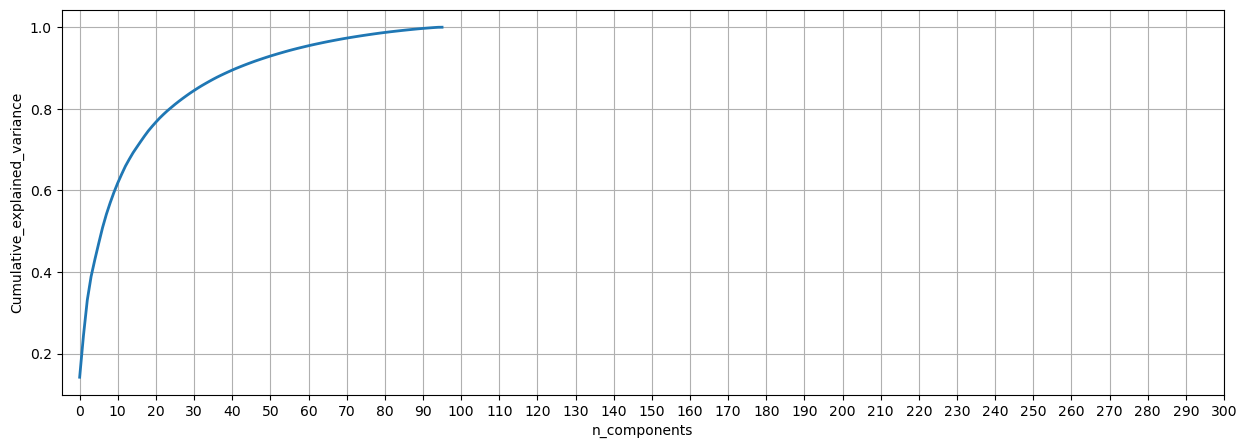

In [23]:
from sklearn.decomposition import PCA
pca = PCA(random_state=13)

# PCA for dimensionality redcution (non-visualization)

pca.n_components = 96
pca_data = pca.fit_transform(pd.DataFrame(vectars))

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(figsize=(15, 5))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.xticks([i for i in range(0,310,10)])
plt.ylabel('Cumulative_explained_variance')
plt.show()


# If we take 75-dimensions, approx. 90% of variance is expalined.

In [24]:
pca.n_components = 30
pca_data = pca.fit_transform(pd.DataFrame(vectars))
pca_data.shape

(49689, 30)

In [25]:
vectars = pd.DataFrame(pca_data)
vectars.columns = ["pca"+str(i) for i in vectars.columns]
vectars['product_id'] = all_items.product_id
vectars.head(3)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,product_id
0,1.498937,-1.589332,0.387976,0.049271,-0.440094,0.075554,-0.532585,0.245523,-0.164432,0.283531,...,0.556449,0.120204,-0.043699,0.078888,0.041931,-0.034851,-0.002820,0.500117,-0.302017,1
1,-0.367498,-1.780468,1.056095,0.284960,0.203071,-0.444052,-0.107263,-0.434135,-0.235681,-0.224727,...,0.317045,0.035234,-0.053770,0.094034,-0.141728,-0.182038,-0.168981,0.201393,-0.166697,78
2,1.055005,-1.937629,0.872188,-0.279977,-0.380692,-0.394946,-0.410173,-0.079100,-0.169786,0.106663,...,0.131567,0.079392,-0.082352,0.368636,-0.049858,0.102755,0.077567,0.147548,-0.184746,102


In [26]:
pickle.dump(vectars,open('products_pca.pkl','wb'))

In [27]:
vectars = pickle.load(open('products_pca.pkl','rb'))

In [28]:
products = pd.read_csv('data/products.csv')
product =products.append(pd.DataFrame(np.array([[str(None),str(None),str(None),str(None)]])
                                     ,columns=['product_id','product_name','aisle_id','department_id'] ) )

C:\Users\Pratik\AppData\Local\Temp\ipykernel_28044\2300701908.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  product =products.append(pd.DataFrame(np.array([[str(None),str(None),str(None),str(None)]])


In [29]:
product = product[['product_id','product_name']]

In [30]:
product.tail()

,product_id,product_name
49684,49685,En Croute Roast Hazelnut Cranberry
49685,49686,Artisan Baguette
49686,49687,Smartblend Healthy Metabolism Dry Cat Food
49687,49688,Fresh Foaming Cleanser
0,None,None


In [31]:
pro_dict = {}
for i in products.values:
    pro_dict[i[0]] = i[1]

In [32]:
pickle.dump(pro_dict,open('producIdName.pkl','wb'))